Actividad 07: Optimización Heurística
==

Decisiones bajo incertidumbre
--
### Mario Varas Gonzalez, Jaime Alberto Henao, Yubar Daniel Marín, Juan Manuel Mejía

Parte 2: Problema del vendedor viajero
==

Se desarrollará la solución del problema del vendedor viajero a partir de optimización por colonia de hormigas y algoritmos genéticos. 

### Instalación de Librerías a utilizar

**plotly:** Creación de gráficos interactivos, se usa para representar la solución en mapas

**plotly - orca:** Exportar imágenes estáticas a partir de gráficos de plotly

**ACO - Pants:** Paquete para ejecutar algoritmo de colonia de hormigas

In [1]:
conda install -c plotly plotly=5.1.0

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
conda install -c plotly plotly-orca

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install ACO-Pants

Note: you may need to restart the kernel to use updated packages.


### Importar paquetes

**Algoritmos**

In [4]:
import pants
import math
import random
import numpy as np
import operator
import pandas as pd
import matplotlib.pyplot as plt

**Gráficas**

In [5]:
import plotly.graph_objects as go
import plotly.express as px

Se crea una lista con las ciudades del recorrido, incluyendo su localización geográfica en coordenadas y asignando a cada una un ID con la cual se representa en los modelos desarrollados.

In [6]:
ciudades = pd.read_csv('D:\DBI\ciudades.csv')
ciudades.head(n=15)

,ID,CIUDAD,LAT,LON
0,0,Palmira,3.53944,-76.30361
1,1,Pasto,1.21361,-77.28111
2,2,Tulua,4.08466,-76.19536
3,3,Bogota,4.60971,-74.08175
4,4,Pereira,4.81333,-75.69611
5,5,Armenia,4.53389,-75.68111
6,6,Caldas,5.89106,-75.63569
7,7,Valledupar,10.46314,-73.25322
8,8,Monteria,8.74798,-75.88143
9,9,Soledad,10.68843,-74.76459


Se importa la matriz de costos de viaje entre cada par de ciudades creada externamente. El indicador de fila y columna corresponde con el ID de cada ciudad. La matriz de costos de viaje entre ciudades se observa en la siguiente tabla.

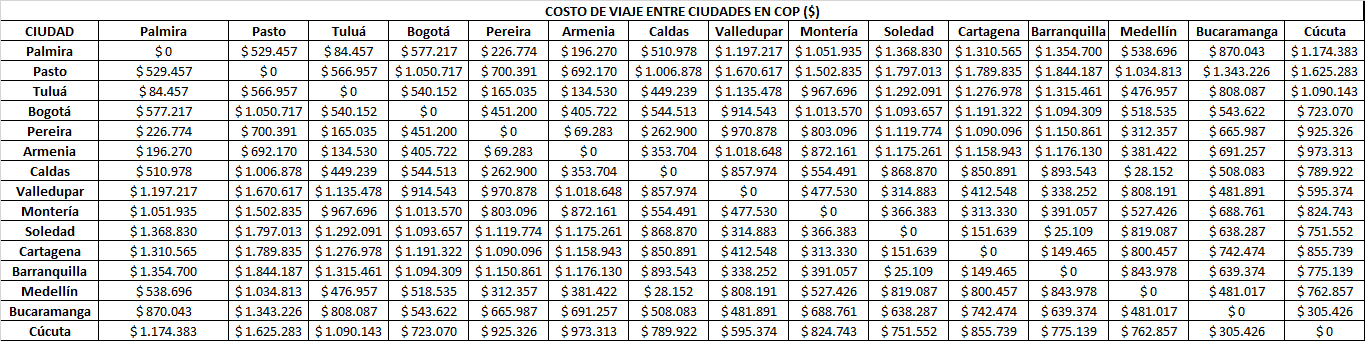

Cada uno de los elementos de la matriz es un costo total de viaje entre dos ciudades, obtenido a partir de:

$$C_T = C_G + C_P + C_H$$ 

Donde $C_G$ es el costo de la gasolina requerida para el recorrido, $C_P$ el costo de los peajes y $C_H$ los costos por pago de salarios al vendedor.

El costo de la gasolina $C_G$ se calcula como el producto de la distancia del recorrido en $[km]$ (obtenida de Google Maps), el consumo promedio del vehículo en $[\frac{gal}{km}]$ y el precio de la gasolina en $[\frac{$}{gal}]$ :

$$C_G = d * cp * pg$$

El automóvil considerado para el ejercicio es un Volkswagen Crafter 35 2020, cuyo consumo promedio $cp$ es de $\frac{1}{41,4} [\frac{gal}{km}]$ y cuyo combustible es gasolina corriente, con precio promedio $pg$ para Colombia de $9000 [\frac{$}{gal}]$.

Por su parte, los costos de peaje $C_P$ por recorrido se consultan directamente de https://www.viajaporcolombia.com/, considerando la categoría I (Microbuses).

Finalmente, los honorarios del vendedor $C_H$ se calculan como el producto de los tiempos de recorrido, consultados en Google Maps y redondeados a múltiplos de $O,5$ y el costo de hora hombre del vendedor, aproximado a 40.000 pesos colombianos.

La tabla anterior se guarda en un archivo .txt para ser importada como la matriz que es usada en la optimización.

In [7]:
file = 'D:\DBI\costos_tsp.txt'
costos = np.loadtxt(file, delimiter = '\t')
print(costos)

[[      0.  529457.   84457.  577217.  226774.  196270.  510978. 1197217.
  1051935. 1368830. 1310565. 1354700.  538696.  870043. 1174383.]
 [ 529457.       0.  566957. 1050717.  700391.  692170. 1006878. 1670617.
  1502835. 1797013. 1789835. 1844187. 1034813. 1343226. 1625283.]
 [  84457.  566957.       0.  540152.  165035.  134530.  449239. 1135478.
   967696. 1292091. 1276978. 1315461.  476957.  808087. 1090143.]
 [ 577217. 1050717.  540152.       0.  451200.  405722.  544513.  914543.
  1013570. 1093657. 1191322. 1094309.  518535.  543622.  723070.]
 [ 226774.  700391.  165035.  451200.       0.   69283.  262900.  970878.
   803096. 1119774. 1090096. 1150861.  312357.  665987.  925326.]
 [ 196270.  692170.  134530.  405722.   69283.       0.  353704. 1018648.
   872161. 1175261. 1158943. 1176130.  381422.  691257.  973313.]
 [ 510978. 1006878.  449239.  544513.  262900.  353704.       0.  857974.
   554491.  868870.  850891.  893543.   28152.  508083.  789922.]
 [1197217. 1670617. 

Optimización con Colonias de Hormigas usando ACO - PAnts
--

La librería Pants requiere de la creación de una objeto de clase "mundo" que recorrerán las hormigas, definido a partir de una serie de "nodos" que serán las ciudades y la función de "trabajo" para recorrer las mismas, que en el presente caso es el costo de viaje.

Se crea entonces una lista de ciudades como nodos requeridos en parámetros de Pants, a partir del ID ya asociado a cada una.

In [8]:
ciudad_id = []
for i in range(15):
  ciudad_id.append(i)

Definir la función de "trabajo" requerida como parámetro para crear el "mundo" que se recorrerá con Pants. Los parámetros de la función son dos ciudades, y esta encuentra el costo de viaje entre las mismas desde la matriz "costos".

In [9]:
def costo_viaje(a,b):
  return(costos[a][b])

Crear el "mundo" a partir de los nodos y la función de "longitud". Se verifican los nodos del mundo.

In [10]:
world = pants.World(ciudad_id, costo_viaje)
world.nodes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Se crea el Solver:

In [11]:
solver = pants.Solver()

Se optimiza el problema con el solver, encontrando la mejor solución:

In [12]:
solution = solver.solve(world)

Se inspecciona la solución, inicialmente el costo total del mejor recorrido:

In [13]:
print(solution.distance)

4934131.0


Luego el orden de las ciudades visitadas:

In [14]:
print(solution.tour)

[7, 9, 11, 10, 8, 12, 6, 4, 5, 2, 0, 1, 3, 13, 14]


Para la representación gráfica de la solución en mapas de Plotly, se requiere crear inicialmente una capa de líneas correcpondiente a los recorridos realizados, indicando las coordenadas (latitud y longitud) de origen y final en cada uno. Para tal fin se crea el DataFrame "recorridos".

In [111]:
recorrido_id = []
for i in range(15):
  recorrido_id.append(i)

lat_ini = []
for i in range(15):
  lat_ini.append(ciudades['LAT'][solution.tour[i]]) #Los recorridos se indexan en el orden dado por la solución de la optimización

lon_ini = []
for i in range(15):
  lon_ini.append(ciudades['LON'][solution.tour[i]])

lat_fin = []
for i in range(14):
  lat_fin.append(ciudades['LAT'][solution.tour[i+1]])
lat_fin.append(ciudades['LAT'][solution.tour[0]]) #El punto final del último recorrido es el origen

lon_fin = []
for i in range(14):
  lon_fin.append(ciudades['LON'][solution.tour[i+1]])
lon_fin.append(ciudades['LON'][solution.tour[0]]) #El punto final del último recorrido es el origen

recorridos = pd.DataFrame()
recorridos['ID'] = recorrido_id
recorridos['LAT_INI'] = lat_ini
recorridos['LAT_FIN'] = lat_fin
recorridos['LON_INI'] = lon_ini
recorridos['LON_FIN'] = lon_fin

recorridos.head(n=15)

,ID,LAT_INI,LAT_FIN,LON_INI,LON_FIN
0,0,10.46314,10.68843,-73.25322,-74.76459
1,1,10.68843,10.96854,-74.76459,-74.78132
2,2,10.96854,10.39972,-74.78132,-75.51444
3,3,10.39972,8.74798,-75.51444,-75.88143
4,4,8.74798,6.25184,-75.88143,-75.56359
5,5,6.25184,5.89106,-75.56359,-75.63569
6,6,5.89106,4.81333,-75.63569,-75.69611
7,7,4.81333,4.53389,-75.69611,-75.68111
8,8,4.53389,4.08466,-75.68111,-76.19536
9,9,4.08466,3.53944,-76.19536,-76.30361


Se crean las imágenes del mapa con los recorridos realizados. Se guarda una imagen por cada recorrido para generar el gif posteriormente.

In [17]:
# Debemos recorrer cada registro
for i in range(len(recorridos)+1): 

# Creamos la figura
    fig = go.Figure()
    
    # Carga de la capa de líneas (recorridos)
    for k in range(i):
        fig.add_trace(  # Añadir el trazo a la figura
            go.Scattergeo(
            # Especificamos la longitud y la latitud en dos variables,
            # extrayendo los valores de los campos del csv del recorrido
            lon = [recorridos['LON_INI'][k], recorridos['LON_FIN'][k]],
            lat = [recorridos['LAT_INI'][k], recorridos['LAT_FIN'][k]],
            mode = 'lines',
            line = dict(width = 5,color = 'red')
          )
        )
     
    # Carga de la capa de puntos (ciudades)
    fig.add_trace(go.Scattergeo(
        lon = ciudades['LON'],
        lat = ciudades['LAT'],
        text = ciudades['CIUDAD'],
        mode = 'text + markers', #Presentar texto y marcadores en el mapa
        textfont = dict(
        color = 'white',
        size = 20),
        marker = dict(
            size = 5,
            color = 'red',
            line = dict(
                width = 0.5,
                color = 'white'
            )
        )))

    # Especificamos características del mapa base y la proyección
    fig.update_geos(fitbounds="locations") #Aplicar zoom automático sobre las ubicaciones activas
    fig.update_layout(
         title_text = 'Ruta del vendedor viajero',
        showlegend = False,
        height = 1200,
        width = 1200,
        geo = dict(
            scope='south america',
            resolution=110,
            projection = dict(
                type = 'orthographic',
                rotation = dict(
                    lon = -70,
                    lat = 5,
                    roll = 0
                )
            ),

            showcoastlines=True,
            showocean=True,
            showcountries=True,
            countrycolor='#829199',
            oceancolor='#132630',
            lakecolor='#132630',
            coastlinecolor='#829199',
            landcolor='#224354',
        )
    )

    fig.write_image('D:\DBI\images/Fig_Pants'+ str(i) + '.jpg') #Guardar imagen de la iteración


El recorrido se observa gráficamente en el siguiente GIF:

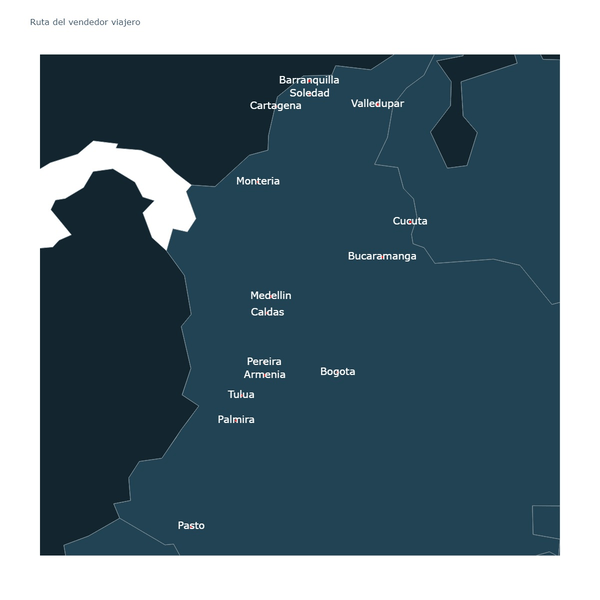

Optimización con Algoritmos Genéticos
--

Se crean las clases "City" para ingresar los datos de las ciudades y las "distancias" entre ellas, siendo la distancia el costo de viaje entre cada par de ciudades obtenido a partir de la matriz "costos".

In [91]:
class City:
    def __init__(self, x):
        self.x = x
    
    def distance(self, city):
        distance = costos[self.x][city.x]
        return distance
    
    def __repr__(self):
        return str(self.x)

Se crea la clase "Fitness", como el inverso de la "distancia" de cada recorrido. En el ejercicio se busca maximizar el "Fitness".

In [92]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

Se crea una población inicial, o primera generación. Inicialmente se requiere crear una función que produzca los recorridos. Para crear un individual, se selecciona aleatoriamente el orden en el que se visita cada ciudad.

In [93]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

Luego se crea una población entera, haciendo un loop de la función anterior para tantas rutas como se desee en la primera población, la cuál se indicará como parámetro al correr el GA.

In [94]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

Se crea una función que "rankee" cada individuo de la población de acuerdo con su "Fitness". La salida será una lista ordenada con el ID de cada ruta y su "Fitness" asociado.

In [95]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

Se seleccionan los "padres" que serán usados para crear la siguiente "generación". El "Fitness" de cada incividuo relativo a la población se usa para asignar una probabilidad de ser seleccionado.

In [96]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum() 
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum() # se calculan el peso relativo del "Fitness" de cada individuo
    
    for i in range(0, eliteSize): #Se mantienen las rutas mejor "rankeadas" en la población inicial
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize): #Se comparan los pesos respecto a un número aleatorio para seleccionar padres
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

A partir de los ID de las rutas seleccionadas, se crea el "grupo de apareamiento". Se extraen los individuos seleccionados de la población inicial.

In [97]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Con el "grupo de apareamiento" creado, se crea la siguiente generación a través de un proceso de "crossover" o "crianza". Se selecciona un subgrupo aleatorio del primer "padre" y se llena el restante de la ruta con "genes" (recorridos) del segundo "padre", sin duplicar genes en el subgrupo seleccionado en el primer padre.

In [98]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Se generaliza lo anterior para crear la población "descendencia". Se usa elitismo para retener las mejores rutas de la población actual, y se usa la función "breed" para rellenar el resto de la siguiente generación.

In [99]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize): # Se retienen las mejores rutas de la población actual
        children.append(matingpool[i])
    
    for i in range(0, length): # Se completa la siguiente generación usando la función "breed"
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

Ahora bien, se incluye también mutación, que busca evitar convergencias locales a través de la introducción de rutas novedosas que exploren otras partes del espacio solución. La función intercambia lugares de dos ciudades de la ruta, con una probabilidad relativamente baja que se especificará. Inicialmente se hace para un individuo.

In [100]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Luego para toda la nueva población.

In [101]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Se genera la función para crear una nueva "generación" las veces que sea indicado al correr el algoritmo.

In [102]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen) # Se "rankean" las rutas en la generación actual
    selectionResults = selection(popRanked, eliteSize) # Se determinan los potenciales padres
    matingpool = matingPool(currentGen, selectionResults) # Se crea el grupo de apareamiento con los padres seleccionados
    children = breedPopulation(matingpool, eliteSize) # Se crea una nueva generación
    nextGeneration = mutatePopulation(children, mutationRate) # Se aplica mutación en la creación de la nueva generación
    return nextGeneration

Finalmente, se crea el algoritmo genético. Se crea la población inicial y se indica repetición en tantas generaciones como sea deseado.

In [103]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1])) # Mostrar mejor recorrido (costo total de viaje) de población inicial
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1])) # Mostrar mejor recorrido (costo total de viaje) de la última generación
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute # Mostrar la mejor ruta obtenida en la última generación

Se corre el algoritmo. Inicialmente se crea una lista con el ID de las ciudades que serán recorridas.

In [104]:
cityList = []
for i in range(15):
    cityList.append(City(x=i))
print(cityList)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


Luego se corre el GA con los parámetros indicados de población de cada generación, individuos élite de cada generación, tasa (probabilidad) de mutación y número de generaciones.Se guarda la mejor ruta como solución_GA.

In [131]:
solucionGA = geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=100)

Initial distance: 8743701.0
Final distance: 4920244.0


In [132]:
print(solucionGA)

[2, 0, 1, 4, 6, 12, 8, 10, 11, 9, 7, 14, 13, 3, 5]


Los elementos de la lista "solucionGA" son de la clase "City". Para poder graficarlos se crea un vector con los mismos elementos pero en representación numérica.

In [133]:
solucionGA_num = [2, 0, 1, 4, 6, 12, 8, 10, 11, 9, 7, 14, 13, 3, 5]

Para representar gráficamente la solución se utiliza el mismo procedimiento usado en el método de colonias de hormigas. Inicialmente se crea el DataFrame con los recorridos ordenados según la solución por GA.

In [134]:
recorridoGA_id = []
for i in range(15):
  recorridoGA_id.append(i)

lat_ini_GA = []
for i in range(15):
  lat_ini_GA.append(ciudades['LAT'][solucionGA_num[i]]) #Los recorridos se indexan en el orden dado por la solución de la optimización

lon_ini_GA = []
for i in range(15):
  lon_ini_GA.append(ciudades['LON'][solucionGA_num[i]])

lat_fin_GA = []
for i in range(14):
  lat_fin_GA.append(ciudades['LAT'][solucionGA_num[i+1]])
lat_fin_GA.append(ciudades['LAT'][solucionGA_num[0]]) #El punto final del último recorrido es el origen

lon_fin_GA = []
for i in range(14):
  lon_fin_GA.append(ciudades['LON'][solucionGA_num[i+1]])
lon_fin_GA.append(ciudades['LON'][solucionGA_num[0]]) #El punto final del último recorrido es el origen

recorridos_GA = pd.DataFrame()
recorridos_GA['ID'] = recorridoGA_id
recorridos_GA['LAT_INI'] = lat_ini_GA
recorridos_GA['LAT_FIN'] = lat_fin_GA
recorridos_GA['LON_INI'] = lon_ini_GA
recorridos_GA['LON_FIN'] = lon_fin_GA

recorridos_GA.head(n=15)

,ID,LAT_INI,LAT_FIN,LON_INI,LON_FIN
0,0,4.08466,3.53944,-76.19536,-76.30361
1,1,3.53944,1.21361,-76.30361,-77.28111
2,2,1.21361,4.81333,-77.28111,-75.69611
3,3,4.81333,5.89106,-75.69611,-75.63569
4,4,5.89106,6.25184,-75.63569,-75.56359
5,5,6.25184,8.74798,-75.56359,-75.88143
6,6,8.74798,10.39972,-75.88143,-75.51444
7,7,10.39972,10.96854,-75.51444,-74.78132
8,8,10.96854,10.68843,-74.78132,-74.76459
9,9,10.68843,10.46314,-74.76459,-73.25322


Luego se crean las imágenes de la solución por GA.

In [135]:
# Debemos recorrer cada registro
for i in range(len(recorridos_GA)+1): 

# Creamos la figura
    fig_GA = go.Figure()
    
    # Carga de la capa de líneas (recorridos)
    for k in range(i):
        fig_GA.add_trace(  # Añadir el trazo a la figura
            go.Scattergeo(
            # Especificamos la longitud y la latitud en dos variables,
            # extrayendo los valores de los campos del csv del recorrido
            lon = [recorridos_GA['LON_INI'][k], recorridos_GA['LON_FIN'][k]],
            lat = [recorridos_GA['LAT_INI'][k], recorridos_GA['LAT_FIN'][k]],
            mode = 'lines',
            line = dict(width = 5,color = 'red')
          )
        )
     
    # Carga de la capa de puntos (ciudades)
    fig_GA.add_trace(go.Scattergeo(
        lon = ciudades['LON'],
        lat = ciudades['LAT'],
        text = ciudades['CIUDAD'],
        mode = 'text + markers', #Presentar texto y marcadores en el mapa
        textfont = dict(
        color = 'white',
        size = 20),
        marker = dict(
            size = 5,
            color = 'red',
            line = dict(
                width = 0.5,
                color = 'white'
            )
        )))

    # Especificamos características del mapa base y la proyección
    fig_GA.update_geos(fitbounds="locations") #Aplicar zoom automático sobre las ubicaciones activas
    fig_GA.update_layout(
         title_text = 'Ruta del vendedor viajero por Algoritmos Genéticos',
        showlegend = False,
        height = 1200,
        width = 1200,
        geo = dict(
            scope='south america',
            resolution=110,
            projection = dict(
                type = 'orthographic',
                rotation = dict(
                    lon = -70,
                    lat = 5,
                    roll = 0
                )
            ),

            showcoastlines=True,
            showocean=True,
            showcountries=True,
            countrycolor='#829199',
            oceancolor='#132630',
            lakecolor='#132630',
            coastlinecolor='#829199',
            landcolor='#224354',
        )
    )

    fig_GA.write_image('D:\DBI\images/Fig_GA'+ str(i) + '.jpg') #Guardar imagen de la iteración


El recorrido resultante se observa gráficamente en el siguiente GIF:

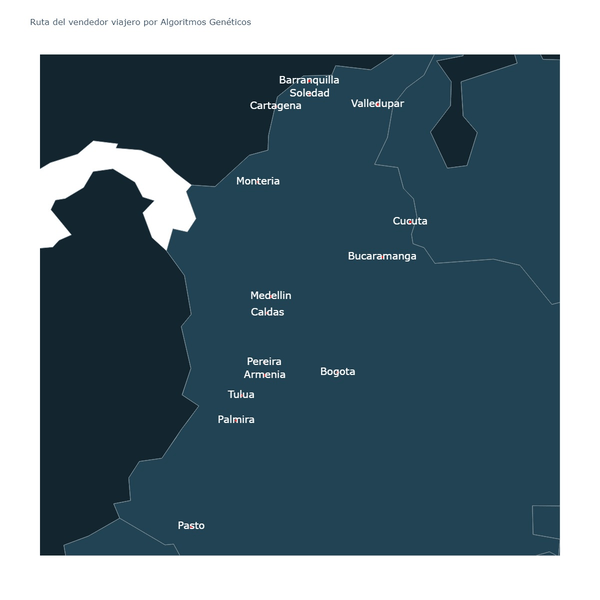

Adicionalmente, se crea una función alternativa para representar el recorrido de menor costo en cada una de las generaciones, para representar cómo varía este en el tiempo.

In [118]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

Se corre el algoritmo con la nueva función:

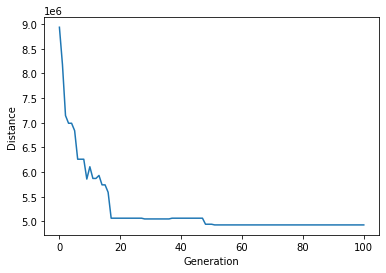

In [122]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=100)

Conclusiones:
--

- La ruta encontrada por el algoritmo genético resultó de menor costo respecto a la obtenida con colonias de hormigas. Específicamente, el recorrido del algoritmo genético representa un costo total de 4'920.244 COP,  mientras que el obtenido con colonias de hormigas fue de 4'934.131 COP.

- En contraparte, los tiempos de cómputo del algoritmo de colonias de hormigas es significativamente menor. El algoritmo genético implementado tiene una estructura más compleja, que no se basa en paquetes existentes.

- Si bien se observa que la solución óptima del algoritmo genético se alcanza aproximadamente a partir de la 60va generación, al correr el algoritmo en varias oportunidades se observó que en algunos casos, con menos de 100 generaciones, la solución arrojada era la misma de colonias de hormigas. Esto explica la sensibilidad respecto a los individuos de la primera generación.


Referencias:
--

- Stoltz, E; Evolution of a salesman: A complete genetic algorithm tutorial for Python. https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35

- Estévez, R; Visualizando datos espaciales con Plotly y Jupyter Notebook. http://www.geomapik.com/desarrollo-programacion-gis/mapas-plotly-visualizacion-datos-espaciales/

- Grant, R; ACO-Pants 0.5.2. https://pypi.org/project/ACO-Pants/
